In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [4]:
d, Nobs = 20_000, 22_000
X = sprandn(d, Nobs, 5e-2)
X[1,:] = ones(Nobs)
nz = 300
ξ_true = spzeros(d)
ξ_true[1] = 3*rand()
nzind = sample(1:d, nz)
ξ_true[nzind[1:Int(nz/2)]] = rand(Uniform(5,10),Int(nz/2))
ξ_true[nzind[Int(nz/2)+1:end]] = -rand(Uniform(5,10),Int(nz/2));
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

In [6]:
xxt = X*X'
print(sum(xxt .== 0.))
xxt = nothing 
gc()

0

#### Define prior:

In [7]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [10]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [8]:
mb_size = 120
prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)

@showprogress for i in 2:d 
    weights_het = abs.(X[i,:])./sum(abs.(X[i,:]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


#### Define output scheduler:

In [16]:
A_xi = ones(1,d)/d
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(3*10^7, 10^7)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


#### Define mbsampler + block Gibbs sampler list:

In [17]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(4e4)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [18]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 146.48 mins 
20% attempts in 286.15 mins 
30% attempts in 422.25 mins 
Trimmed after 10000000 bouncing attempts 
40% attempts in 555.76 mins 
50% attempts in 687.63 mins 
60% attempts in 819.07 mins 
70% attempts in 948.8 mins 
80% attempts in 1079.28 mins 
90% attempts in 1209.06 mins 
100% attempts in 1336.12 mins 


In [19]:
print(maximum(abs.(outp.opf.xi_mu - mstate.mu)), "\n")
print(maximum(abs.(outp.opf.xi_m2 - mstate.m2)))

0.7561800066688873
2.21409460778223

* Number of bounces:

In [20]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tot_bounces-sum(mstate.n_bounces)
@printf("ZZ total bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ total bounces: 709574, hyper bounces: 64664

In [21]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.014089666666666667

In [22]:
post_mean_gzz = outp.opf.xi_mu
# post_median_gzz = median(xi_samples,2);

### Credible intervals:

In [23]:
xi_sd = sqrt.(outp.opf.xi_m2 - outp.opf.xi_mu.^2)
ci = zeros(d,2)
ci[:,1] = outp.opf.xi_mu-3*xi_sd
ci[:,2] = outp.opf.xi_mu+3*xi_sd;

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

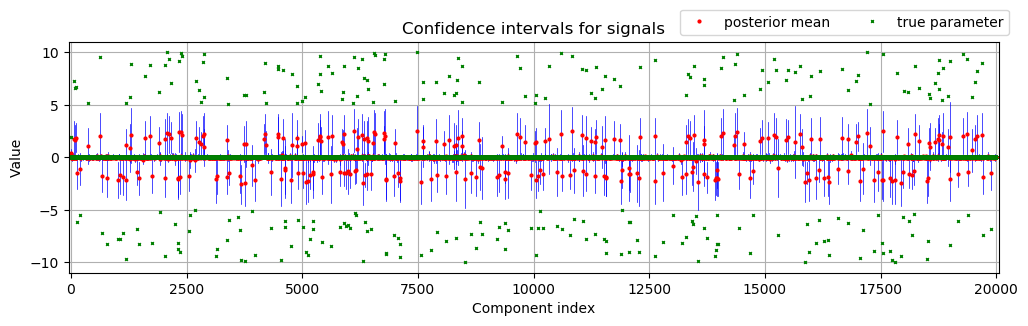

Progress: 100%|█████████████████████████████████████████| Time: 0:02:19


In [24]:
fig = figure(figsize=(12,3))
@showprogress for i in 1:d
    plot([i,i], ci[i,:], "b-", lw=0.5)
end
plot(1:d, outp.opf.xi_mu, "ro", markersize=2, label="posterior mean");
plot(1:d, ξ_true, "gx", markersize=2, label="true parameter")
grid(true)
xlim(-50,d+50)
xlabel("Component index")
ylabel("Value")
title("Confidence intervals for signals")
legend(ncol=2,bbox_to_anchor=(0.65, 1))
savefig("plots/CId20K.pdf", format="pdf", dpi=10000, bbox_inches="tight")

In [25]:
save("/home/postdoc/dsen/Desktop/GZZ_data/data/opf_d20K.jld", "opf", outp.opf, "X", X, "y", y, "xi_true", ξ_true)